In [1]:
import numpy as np
import  json
from  shapely.geometry  import Polygon, Point
import shapely.ops as shops
#from descartes.patch import PolygonPatch
import shapely.vectorized
from datetime import datetime
import matplotlib.pyplot as plt
import xarray as xr
import hvplot.xarray
import pandas as pd
from IPython.display import display, HTML
from scipy import interpolate, signal
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

### Load in the stack of elevation maps
These maps are in rotated cross-shore and alongshore coordinates.
They were generated by Sandwich_maps_local_coords.ipynb


In [3]:
titles = ([\
         "22-Jan-2016",\
         "25-Jan-2016",\
         "11-Feb-2016",\
         "30-Mar-2016",\
         "21-Sep-2016",\
         "09-Jan-2017",\
         "25-Jan-2017",\
         "14-Feb-2017",\
         "16-Mar-2017",\
         "28-Apr-2017",\
         "04-May-2017",\
         "18-Sep-2017",\
#         "03-Jan-2017",\
         "10-Jan-2018",\
         "09-Mar-2018"]
         )

# make a array of time differences between surveys
dt = np.array([ datetime.strptime(titles[i], '%d-%b-%Y') for i in range (len(titles))])
dtt=dt-dt[0]
dts = np.array([dtt[i].total_seconds() for i in range(len(titles))])
dts

array([        0.,    259200.,   1728000.,   5875200.,  20995200.,
        30499200.,  31881600.,  33609600.,  36201600.,  39916800.,
        40435200.,  52272000.,  62121600.,  67132800.])

In [4]:
da = xr.open_dataarray('one_meter_test.nc')
(num_maps,ysize,xsize)=np.shape(da.values)
print('Shape of stacked elevation array: ',num_maps,xsize,ysize)

# use meshgrid to make coordinate arrays
X, Y = np.meshgrid( da.coords['Cross-shore'].values, da.coords['Alongshore'].values )
print('Shape of X and Y',np.shape(X),np.shape(Y))
da

Shape of stacked elevation array:  14 280 1300
Shape of X and Y (1300, 280) (1300, 280)


<xarray.DataArray (map: 14, Alongshore: 1300, Cross-shore: 280)>
array([[[ -3.276700e+04,  -3.276700e+04, ...,  -9.668977e-01,  -9.762037e-01],
        [ -3.276700e+04,  -3.276700e+04, ...,  -9.760453e-01,  -9.674652e-01],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       [[ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        [ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       ..., 
       [[           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        ..., 
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
       

### Plot one of the elevation layers to make sure coords are correct

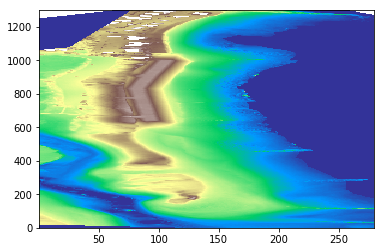

In [5]:
plt.pcolormesh(X, Y, np.squeeze(da[0,:,:]), vmin=-2,vmax=8,cmap=plt.cm.terrain )

### Use json to read in the ROI polygon (drawn in Global mapper, and saved in geojson format)
Use the coordinates to convert to a shapely polygon

Area of polygon: Barrier ROI: 269433.9 m^2


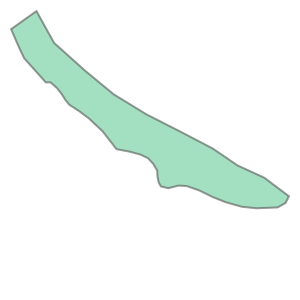

In [6]:
# read the barrier roi
with open('barrier_roi.geojson') as f:
    data = json.load(f)

    # assume there is only one feature, extract coordinates, and convert to array
    a=np.squeeze( data['features'][0]['geometry']['coordinates'] )

    # make a shapely.geometry.Polygon, which requires a sequence of coordinate tuples
    barrier_roi_poly = Polygon(tuple(map(tuple,a)))
    xc=barrier_roi_poly.centroid.x
    yc=barrier_roi_poly.centroid.y
    print("Area of polygon: {} {:.1f} m^2".format('Barrier ROI:',barrier_roi_poly.area))

barrier_roi_poly

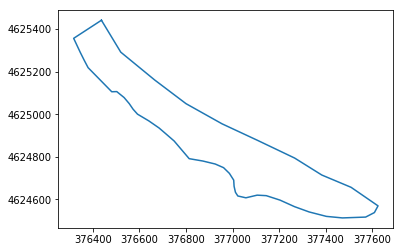

In [7]:
# could extract the UTM boundaries from the polygon, but they are already in a
# xx, yy = barrier_roi_poly.exterior.coords.xy
# xxx=np.array(xx)
# yyy=np.array(yy)
# print(xxx, yyy)
xxx = a[:,0]
yyy = a[:,1]
plt.plot(xxx,yyy)

In [8]:
# This is the function I used to convert box coordinates to UTM
def box2UTMh(x, y, x0, y0, theta):
    '''
    2D rotation and translation of x, y
    Input:
        x, y - row vectors of original coordinates (must be same size)
        x0, y0 - Offset (location of x, y = (0,0) in new coordinate system)
        theta - Angle of rotation (degrees, CCW from x-axis == Cartesian coorinates)
    Returns:
        xr, yr - rotated, offset coordinates
    '''
    thetar = np.radians(theta)
    c, s = np.cos(thetar), np.sin(thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix
    Th = np.array(((1., 0., x0),\
                   (0., 1., y0),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    xr = xyrh[0,:]
    yr = xyrh[1,:]
    return xr, yr

### Test cell to check conversion from UTM to box (cross-shore, alongshore) coordinates

[ 377270.          376245.58602031  376417.9712334   377442.38521309] [ 4624440.          4625240.35991792  4625461.00292893  4624660.64301101]
[  0.00000000e+00   3.69368536e-10   2.80000000e+02   2.80000000e+02] [  0.00000000e+00   1.30000000e+03   1.30000000e+03   2.05233164e-10]


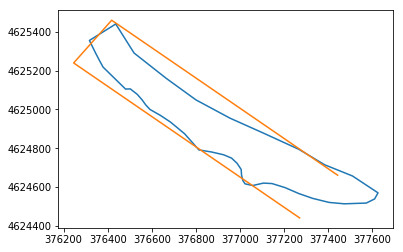

In [9]:
# These values must match those used to define the box in Sandwich_maps_local_coords.ipynb
x0 = 377270.; y0 = 4624440.
theta = 52.

# here are the local coordinates of corners of the box
xb = np.array((0., 0., 280., 280.))
yb = np.array((0., 1300., 1300., 0.))

# convert to UTM
xr,yr = box2UTMh(xb, yb, x0, y0,theta)
print(xr,yr)

# invert back to box as a check (remove offset first, then reverse rotation)
xur,yur = box2UTMh(xr-x0, yr-y0, 0., 0., -theta)
print(xur,yur)

# plot the box overlaid on roi in local coordinates
plt.plot(xxx,yyy)
plt.plot(xr,yr)

### Define an inverse function for shapely to convert from UTM to local cross-shelf / alongshore coord system

In [10]:
def UTM2box_func(x, y, z=None):
    '''
    Implement coordinate transformation used to rotate DEMs to box ROI
    I am not sure how to pass arguments to this through shapely,
    so make sure that x0, y0, and theta are same as used in
    box2UTMh(x, y, x0, y0, theta)
    
    This function first removes the offset, then does a reverse rotation using
    the hard-wired values.
    '''
    x0 = 377270.; y0 = 4624440.
    theta = 52.
    
    x = x-x0
    y = y-y0
    
    thetar = np.radians(theta)
    c, s = np.cos(-thetar), np.sin(-thetar)

    # homogenous rotation matrix
    Rh = np.array(((c, -s,  0.),\
                   (s,  c,  0.),\
                   (0., 0., 1.)))
    # homogenous translation matrix (not really needed in this inverse transform)
    Th = np.array(((1., 0., 0.),\
                   (0., 1., 0.),\
                   (0., 0., 1.)))
    
    # homogenous input x,y
    xyh = np.vstack((x,y,np.ones_like(x)))

    # perform rotation and translation
    xyrh=np.matmul(np.matmul(Th,Rh),xyh)
    
    # overwrite input arrays
    x = xyrh[0,:]
    y = xyrh[1,:]
    
    # return tuple(filter(None, [x, y, z])) # complains about ambiguous
    return (x,y)

### Transform the UTM polygon to rotated coords

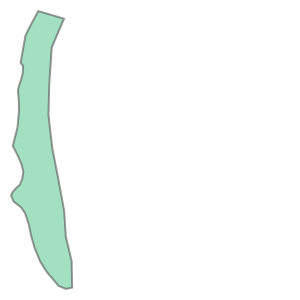

In [11]:
# This calls the inverse transform function
roi=shops.transform(UTM2box_func,barrier_roi_poly)
roi

In [12]:
xx, yy = roi.exterior.coords.xy
xx

array('d', [276.0229760136282, 135.57810953934484, 101.29743643240761, 81.93558148092347, 65.16617852985644, 38.548752604862216, 52.40370026319715, 49.83164108386757, 40.921116986020024, 30.408652062330418, 23.77263655070982, 28.810814274324343, 29.654599959217705, 26.340674189354957, 21.37589956502103, -4.271408622115985, 23.17761730111863, 44.92406250265054, 53.45144722002979, 47.76926010684517, 34.12221174525541, 12.2168150140497, -6.248283713488576, -13.61393915855217, 0.9584209893675393, 40.62783348091895, 62.84711190475376, 82.74297450270248, 96.91180306546637, 116.04134356880095, 145.2798188152696, 181.9777032245951, 246.52814497128057, 286.5521824224913, 320.9225471806283, 318.2363012793755, 286.23415751118546, 277.184992591934, 244.95049402148567, 211.73771233672065, 191.0388081106127, 195.74267158280207, 209.00243576811232, 276.0229760136282])

Shape of mask:  (1300, 280)


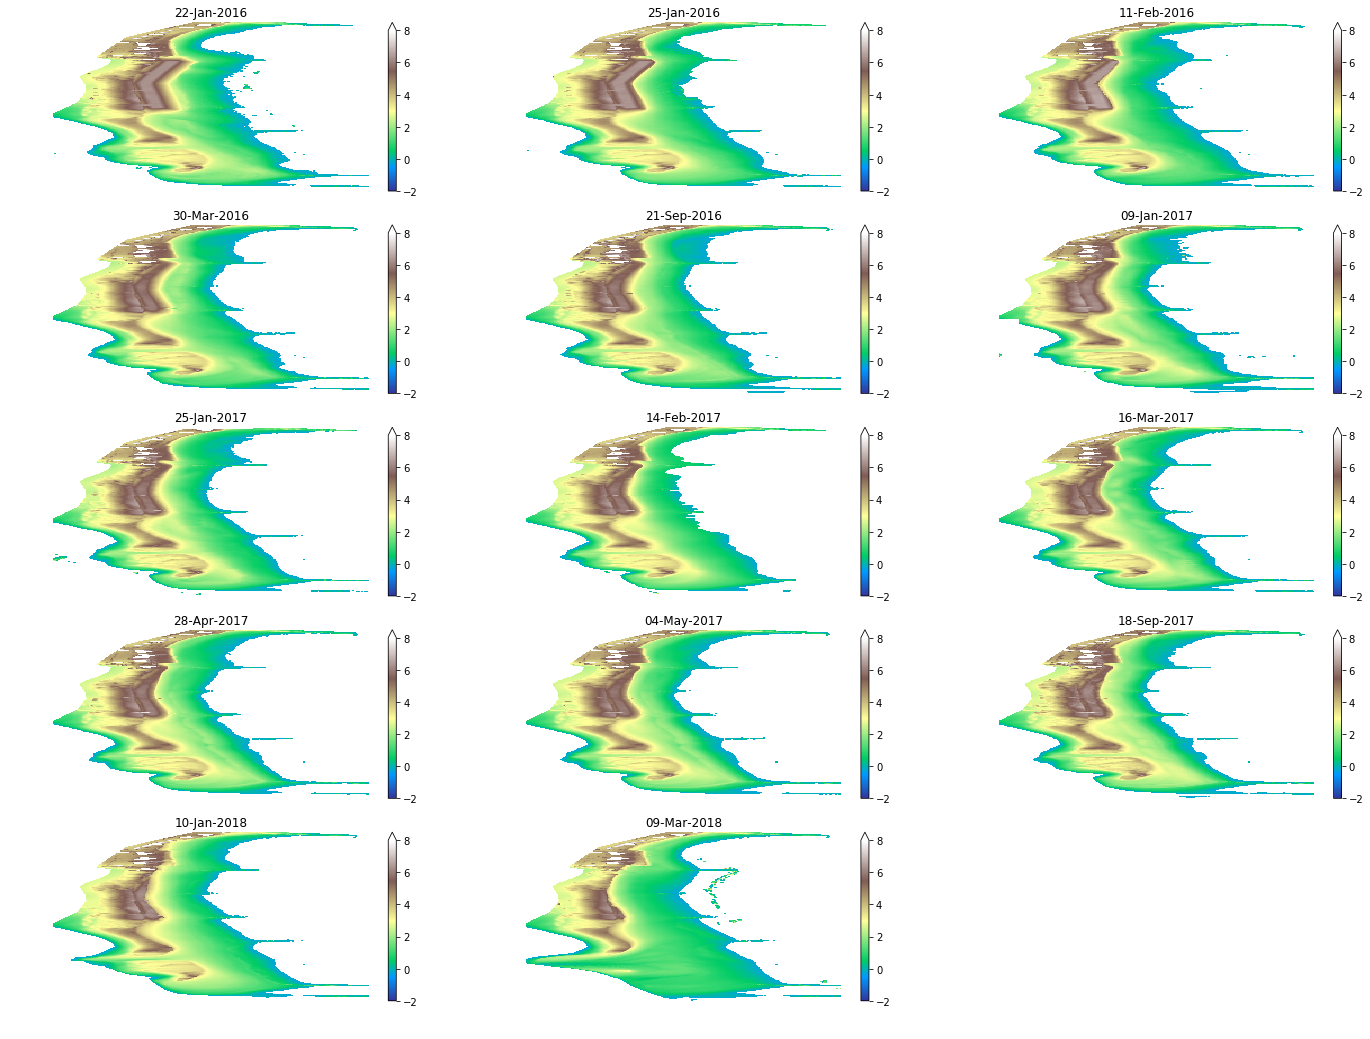

In [13]:
### Make a mask to NaN out regions outside the barrier roi
mask = np.empty((ysize,xsize))
print('Shape of mask: ',np.shape(mask))
# raster mask
mask[:,:] = shapely.vectorized.contains(roi,X,Y)

# have a look at the effect of the mask
mask[mask==0.]=np.NaN
      
# declare a plot size
plt.subplots(figsize=(24,18))
for imapn in range(0,14):
    # small plots of elevation
    plt.subplot(5,3,imapn+1)
    plt.axis('off')

    dam = np.squeeze(da[imapn,:,:]*mask)
#     idx = np.where(dam<-0.2)
#     dam[idx]=np.nan   
    dam.where(dam> -0.2).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
    #plt.pcolormesh(X, Y, dam, vmin=-2,vmax=8,cmap=plt.cm.terrain )
    #cmap.set_under('gray')
    plt.title(titles[imapn])
        
plt.savefig('masked_elevation_time_series.png')

In [14]:
da

<xarray.DataArray (map: 14, Alongshore: 1300, Cross-shore: 280)>
array([[[ -3.276700e+04,  -3.276700e+04, ...,  -9.668977e-01,  -9.762037e-01],
        [ -3.276700e+04,  -3.276700e+04, ...,  -9.760453e-01,  -9.674652e-01],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       [[ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        [ -3.276700e+04,  -3.276700e+04, ...,            nan,            nan],
        ..., 
        [           nan,            nan, ...,            nan,            nan],
        [           nan,            nan, ...,            nan,            nan]],

       ..., 
       [[           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
        ..., 
        [           nan,            nan, ...,  -3.276700e+04,  -3.276700e+04],
       

In [15]:
amap = da[0,:,:]*mask
amap.where(amap> -0.2).sum(dim='Cross-shore')
bmap = da+.2;
bmap = np.array(bmap.where(bmap>0).sum(dim='Cross-shore'))
bmapsum = np.sum(bmap,1)
err = 1.96*np.sqrt(2.*0.08**2)
bmaperrup = np.sum(bmap+err,1)
bmaperrdn = np.sum(bmap-err,1)

print(np.shape(bmapsum),np.shape(bmaperrup))
print(err)
print(np.sum(bmap,1))
print(np.sum(bmap+err,1))

(14,) (14,)
0.22174868658
[ 511468.46111738  491681.55131857  483539.73494241  479079.72210782
  483686.09797864  480957.19389515  472219.04713307  462523.78031211
  451475.37481394  467034.13232924  486243.6902222   479277.64109361
  482342.3069035   440126.79117791]
[ 511756.73440993  491969.82461112  483828.00823497  479367.99540038
  483974.3712712   481245.4671877   472507.32042562  462812.05360467
  451763.6481065   467322.40562179  486531.96351475  479565.91438616
  482630.58019605  440415.06447047]


Text(0,0.5,'Transect Volume [m$^2$]')

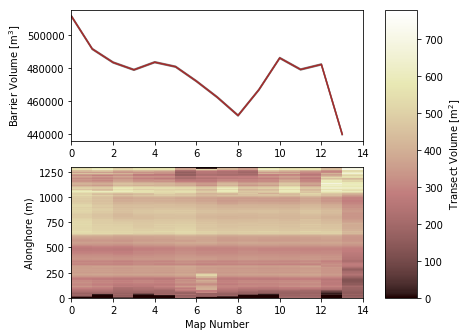

In [16]:
plt.subplots(figsize=(6,5))
plt.subplot(2,1,1)
plt.plot(bmaperrup,'gray')
plt.plot(bmaperrdn,'gray')
plt.plot(bmapsum,'brown')

plt.ylabel('Barrier Volume [m$^3$]')
plt.xlim((0., 14))
plt.subplot(2,1,2)
plt.pcolormesh(bmap.T,cmap=plt.cm.pink )

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.xlabel('Map Number')
plt.ylabel('Alonghore (m)')
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)
plt.ylabel('Transect Volume [m$^2$]')

Shape of bmap:  (14, 1300)
Shape of diff(bmap) (14, 1300)
Shape of bmdiff:  (1300, 14)


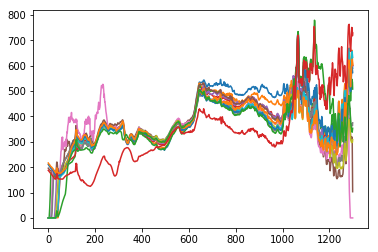

In [29]:
print("Shape of bmap: ",np.shape(bmap))
print("Shape of diff(bmap)",np.shape(np.diff(bmap,0)) )
bmdiff = np.diff(bmap,0).T
print("Shape of bmdiff: ",np.shape(bmdiff))
plt.plot(bmdiff)
#plt.plot(np.sum(bmdiff,1),'black')


In [23]:
bmdiff

array([[  0.        ,   0.        ,   0.        , ...,  -1.62820181,
          0.        ,  -1.24612121],
       [  0.        ,   0.        ,   0.        , ...,  -1.53951858,
          0.        ,  -1.43961646],
       [  0.        ,   0.        ,   0.        , ...,  -1.36270289,
          0.        ,  -1.12581913],
       ..., 
       [ -6.15905498, -24.21447819,  -9.40683127, ...,  -3.33395765,
         -3.41240398,  -0.64521769],
       [ -7.98092318, -15.18942304,  -0.92858808, ...,  -9.83051647,
          6.76416137, -31.47209297],
       [ -8.62371834, -14.23591109, -28.44652381, ...,  -8.59077014,
          8.72396091,  11.43799862]])

In [ ]:
# extract a transect and plot
m = da[0,:,:]
m = m.fillna(0.).where(m>=-2)
plt.plot(np.flip(m[1000,:],0))


In [ ]:
# plot using more native approach
da[0,100,:].plot(xincrease=False)
da[1,100,:].plot(xincrease=False)

In [ ]:
MWLdatum = -0.2
imap = 13
xik = np.ones((1300,1))*np.NaN
xikb = np.ones((1300,1))*np.NaN

# extract the x coords
x = da.coords['Cross-shore'].values
y = da.coords['Alongshore'].values
for itno in range(0,1300):
    # itno = 200

    # extract a transect
    t = np.flip(np.array(da[0,itno,:]),0)

    idx = np.where(t<-100.)
    t[idx]=-10.

    # smooth w/ box (omit later?)
    box_kernel = Box1DKernel(5)
    tsb = convolve(np.array(t), box_kernel)

    # smooth w/ Gauss
    #  size of kernal
    gkn = 5
    #  amount to remove at ends
    gkno2 = int(round(gkn/2.))
    gauss_kernel = Gaussian1DKernel(gkn)
    tsg = convolve(np.array(t), gauss_kernel)
    # NaN the ends?
    # tsg[0:gkno2]=np.NaN
    # tsg[-(gkno2+1):-1]=np.NaN

    # calculate gradients (add a value to keep arrays same length)
    dts = np.append([0.],np.diff(tsg))
    ddts = np.append([1.],np.diff(dts))
    dddts = np.append([1.],np.diff(ddts))

    # look for shoreline
    #   postitive slope
    pos_slope = dts>=5e-5
    #   close to MWL
    close = np.abs(t-(-1.))<=0.05
    xlimit = x<150.
    kdx = np.logical_and( np.logical_and(close, pos_slope), xlimit)
    kdx1 = np.argmax(kdx)
    xik[itno]=x[kdx1]
    
    # look for back of barrier
    neg_slope = dts<=-5e-5
    xextend = x>(xik[itno]+100.)
    #print(sum(neg_slope),sum(xextend))
    kdxb = np.logical_and( np.logical_and(close, neg_slope), xextend )
    kdx2 = np.argmax(kdxb)
    #print('x[kdx2], t[kdx2] =',x[kdx2],t[kdx2]-MWLdatum)
    xikb[itno]=x[kdx2]
    #print(itno,': found ',np.sum(kdxb),' first one:', kdx2)



In [ ]:
from scipy.ndimage.filters import maximum_filter1d, median_filter
xikf = np.zeros_like(xik)
median_filter(xik, 21, output=xikf, mode='nearest')
# try several filters...use the biggest values
xikbf7= np.ones_like(xik)
xikbf21= np.ones_like(xik)
xikbf51= np.ones_like(xik)

median_filter(xikb, 7, output=xikbf7, mode='nearest')
median_filter(xikb, 21, output=xikbf21, mode='nearest')
median_filter(xikb, 51, output=xikbf51, mode='nearest')
xikbf = np.max((np.hstack((xikbf7,xikbf21,xikbf51))),axis=1)

plt.plot(xik)
plt.plot(xikf,'.k')
plt.plot(xikb,'-b')
plt.plot(xikbf,'.c')
plt.xlim(400, 600)

In [ ]:
np.shape(xikbf)

In [ ]:
da.isel(map=imap).plot(vmin=-2,vmax=8,cmap=plt.cm.terrain)
plt.plot(280-xikf,y,'or')
plt.plot(180-xikf,y,'og')
plt.plot(280-xikbf,y,'oy')

In [ ]:
#   first point of points closest to MWL elevation (this does not work if an inland one is closer)
# mlw =  np.argmin(np.abs(t-MWLdatum))

fig, ax = plt.subplots()
plt.plot(x,np.zeros_like(x),'--k')
plt.plot(x,t,label='Data')
plt.plot(x,tsg,label='Gauss')
# plt.plot(x,tsb,label='Box')
plt.plot(x,10*dts)
#plt.plot(x,10*ddts)
plt.plot(x[kdx],t[kdx],'ok',label='MLW')
#plt.plot(x[mlwg],t[mlwg],'ob')
ax.legend()

In [ ]:
xlimit = x<150.

inflection = abs(ddts)<1e2
print(np.argmax(t),np.argmax(tsg))

kdx = np.logical_and( np.logical_and(mlw,pos_slope), xlimit)

In [ ]:
print(np.argmax(t),np.argmax(tsg),np.argmax(tsb))

In [ ]:
# why does this return two values?
# they are indices for rows, columns...even if the array is 1D
kdx = [0, 0, 0, 1, 0, 1, 0]
ii=np.where(kdx)
ii[0][0]

In [ ]:
aa = np.array((1,1,0,3,3,0,3,4,5,6,0,7,8,9,10))
bb = np.zeros_like(aa)
maximum_filter1d(aa, 5, output=bb, mode='nearest')
bb

In [ ]:
sum(xikf-xik)

In [ ]:
plt.plot(s)

In [ ]:
idx = np.where(m[:,:]>0.)

In [ ]:
np.shape(idx)